# Vanilla GAN(Generative Adversarial Network)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

> ## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU

# I. Load MNIST Dataset

* Normalization and Reshape

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
    
# Normalization: -1 ~ 1 Range
X_train = (X_train.astype(float) - 127.5) / 127.5
    
# Reshape
X_train = X_train.reshape(60000, 28 * 28)

11490434/11490434 [==============================] - 2s 0us/step


# II. 'generator' Model

* 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력받아 이미지 생성
 - NOISE_DIM : 입력 랜덤 벡터 크기
* 'discriminator'를 속이도록 학습
 - 'Real Image'와 같은 'Fake Image' 생성이 목적

In [ ]:
NOISE_DIM = 10

generator = Sequential(name = 'generator')

generator.add(Dense(256, input_shape = (NOISE_DIM,)))
generator.add(LeakyReLU())
generator.add(Dense(512))
generator.add(LeakyReLU())
generator.add(Dense(1024))
generator.add(LeakyReLU())
generator.add(Dense(784, activation = 'tanh'))

* Model Summary

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               80

# III. 'discriminator' Model

* 이미지를 입력받아 'Real Image'인지 'generator'가 생성한 'Fake Image' 인지 판별
 - 이진분류

In [ ]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name = 'discriminator')

discriminator.add(Dense(1024, 
                        input_shape = (784,), 
                        kernel_initializer = RandomNormal(stddev = 0.02)))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation = 'sigmoid'))

* Model Summary

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)             

> ## 1) 'discriminator' Compile

* 학습 설정
 - beta_1: Learning Rate 감쇠율 조정

In [ ]:
from tensorflow.keras.optimizers import Adam

discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(lr = 0.0002,
                                       beta_1 = 0.5))

# IV. 'gan' Model

> ## 1) 'generator', 'discriminator' 연결

* 'gan' 모델에서 'generator'만 학습하도록 설정
 - discriminator.trainable = False

In [ ]:
discriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

> ## 2) 'gan' Model

In [ ]:
gan = Model(gan_input, output, name = 'gan')

> ## 3) 'gan' Summary

In [ ]:
gan.summary()

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 generator (Sequential)      (None, 784)               1463312   
                                                                 
 discriminator (Sequential)  (None, 1)                 1460225   
                                                                 
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


> ## 4) 'gan(generator)' Compile

* 학습 설정

In [ ]:
gan.compile(loss = 'binary_crossentropy', 
            optimizer = Adam(lr = 0.0002,
                             beta_1 = 0.5))

# V. Define 'get_batches( )' Function

* MNIST image batch 생성

In [ ]:
def get_batches(data, batch_size):
    batches = []

    for i in range(data.shape[0] // batch_size):
        batch = data[i * batch_size : (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

# VI. 'visualize_training( )' Function

In [ ]:
def visualize_training(epoch, d_losses, g_losses):

    # 오차 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    # 이미지 생성 결과 시각화
    print('epoch :', epoch)
    noise = np.random.normal(0, 1, size = (24, NOISE_DIM))
    generated_images = generator.predict(noise, verbose = 0)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize = (8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# VII. Model Training

* 약 30분
<br>
<br>
* .fit( )
 - 'epoch', 'batch_size' 지정
* .train_on_batch( )
 - 전달 받은 모든 데이터를 사용하여 학습 진행
* 'generator'가 매번 새로운 'Fake Image'를 생성하여 '.train_on_batch( )' 사용

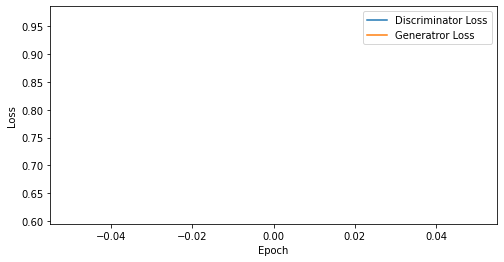

epoch: 1, Discriminator Loss: 0.6126065254211426, Generator Loss: 0.9682331085205078
epoch : 1


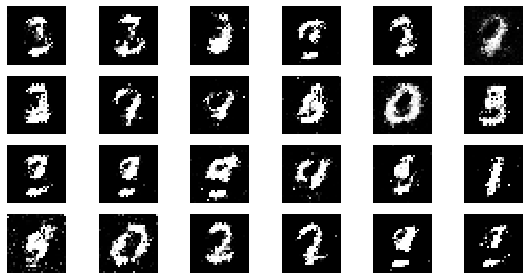

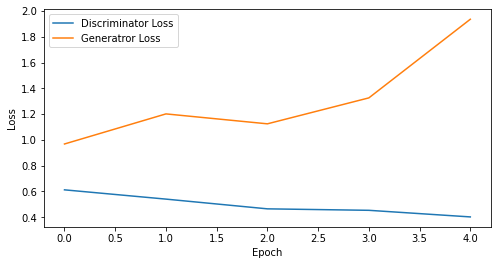

epoch: 5, Discriminator Loss: 0.49501898884773254, Generator Loss: 1.3110875606536865
epoch : 5


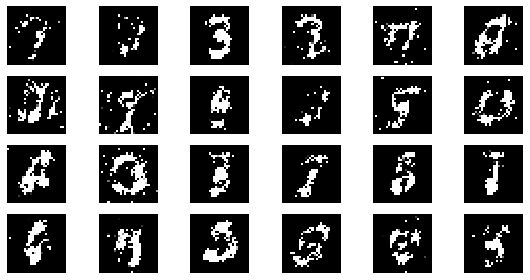

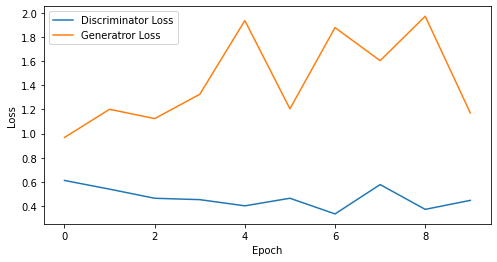

epoch: 10, Discriminator Loss: 0.4675849169492722, Generator Loss: 1.4385298013687133
epoch : 10


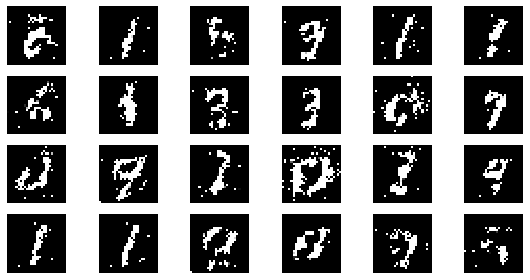

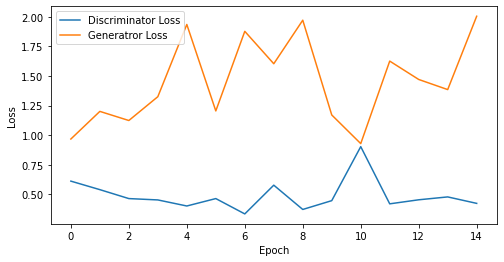

epoch: 15, Discriminator Loss: 0.4906459311644236, Generator Loss: 1.453521223862966
epoch : 15


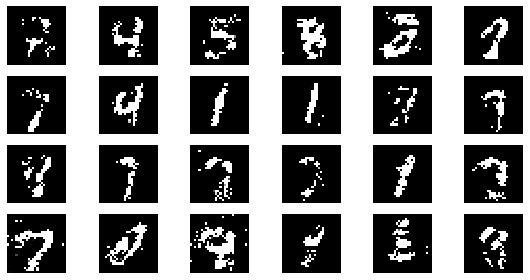

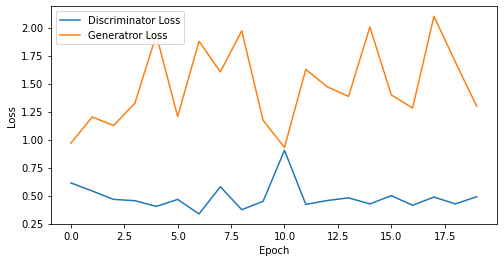

epoch: 20, Discriminator Loss: 0.48362224251031877, Generator Loss: 1.4787315398454666
epoch : 20


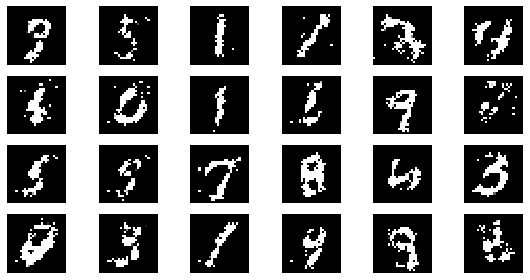

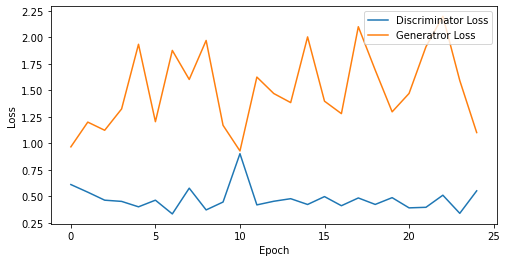

epoch: 25, Discriminator Loss: 0.47480821490287783, Generator Loss: 1.5142036414146423
epoch : 25


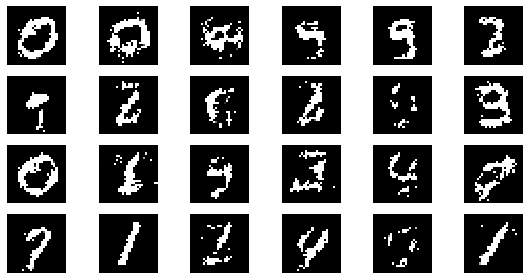

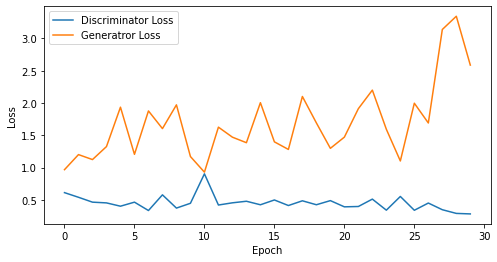

epoch: 30, Discriminator Loss: 0.45279692908128105, Generator Loss: 1.6870445946852366
epoch : 30


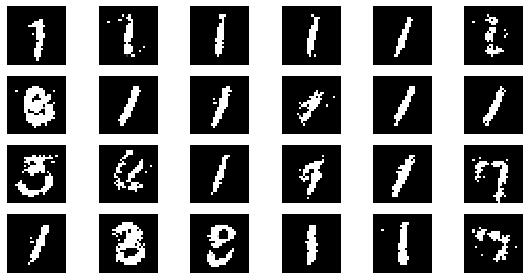

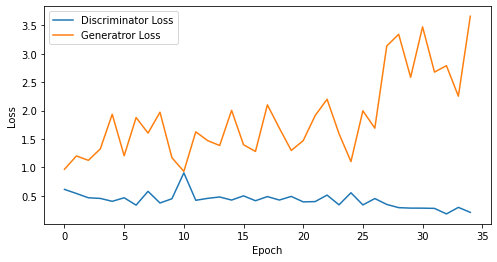

epoch: 35, Discriminator Loss: 0.4237137577363423, Generator Loss: 1.8705783486366272
epoch : 35


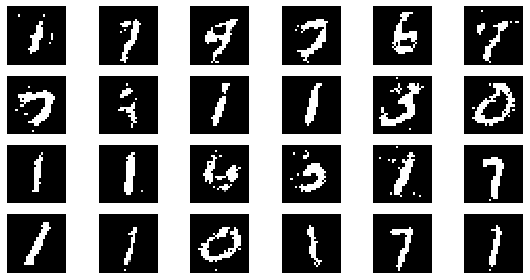

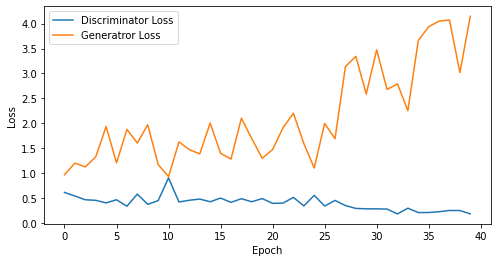

epoch: 40, Discriminator Loss: 0.3986555222421885, Generator Loss: 2.117467062175274
epoch : 40


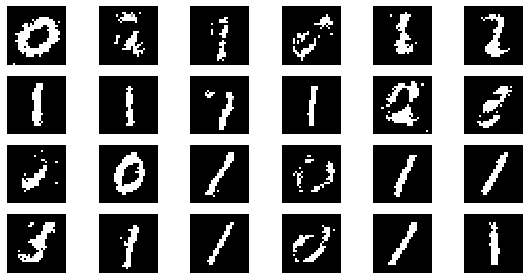

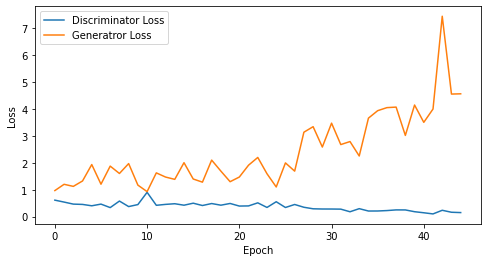

epoch: 45, Discriminator Loss: 0.37198664744695026, Generator Loss: 2.4172048343552484
epoch : 45


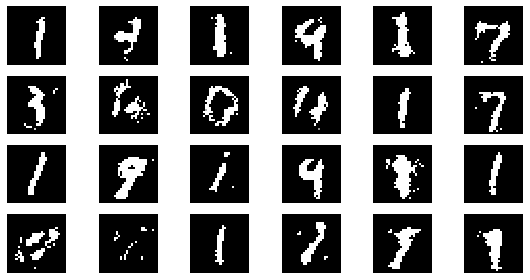

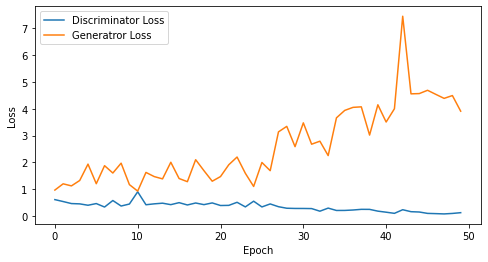

epoch: 50, Discriminator Loss: 0.34461217060685156, Generator Loss: 2.6157441651821136
epoch : 50


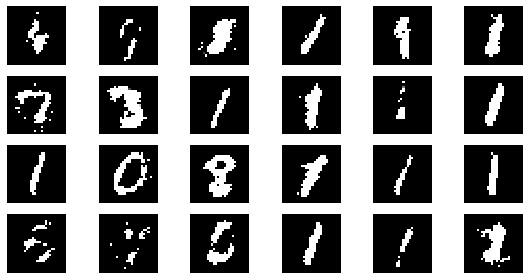

CPU times: user 27min 13s, sys: 1min 14s, total: 28min 28s
Wall time: 29min 14s


In [ ]:
%%time

EPOCHS = 50
BATCH_SIZE = 128

# 'discriminator', 'gan(generator)' Loss 저장 List
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # batch 별 학습
    for real_images in get_batches(X_train, BATCH_SIZE):
        # Random Noise 생성
        input_noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
        
        # Fake Image 데이터 생성
        generated_images = generator.predict(input_noise, verbose = 0)
        
        # 'discriminator' 학습용 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # 'discriminator' 학습용 y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 1
        
        # 'discriminator' 학습
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # 'discriminator' 학습 정지
        discriminator.trainable = False

        # 'gan(generator)' 학습용 X,y 데이터 생성
        noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # 'gan(generator)' 학습
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # 생성 결과 시각화
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)

# 
# 
# 
# The End
# 
# 
# 